<a href="https://colab.research.google.com/github/nnoahtb/support-ticket-priority-ML/blob/main/support_ticket_priority.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import re
from collections import Counter

from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, precision_recall_fscore_support,
    classification_report, ConfusionMatrixDisplay, confusion_matrix
)

import matplotlib.pyplot as plt
import joblib

In [4]:

df = pd.read_csv('support_tickets.csv')

print(df.shape)
df.head()


(28587, 16)


,subject,body,answer,type,queue,priority,language,version,tag_1,tag_2,tag_3,tag_4,tag_5,tag_6,tag_7,tag_8
0,Wesentlicher Sicherheitsvorfall,"Sehr geehrtes Support-Team,\n\nich möchte eine...",Vielen Dank für die Meldung des kritischen Sic...,Incident,Technical Support,high,de,51,Security,Outage,Disruption,Data Breach,NaN,NaN,NaN,NaN
1,Account Disruption,"Dear Customer Support Team,\n\nI am writing to...","Thank you for reaching out, <name>. We are awa...",Incident,Technical Support,high,en,51,Account,Disruption,Outage,IT,Tech Support,NaN,NaN,NaN
2,Query About Smart Home System Integration Feat...,"Dear Customer Support Team,\n\nI hope this mes...",Thank you for your inquiry. Our products suppo...,Request,Returns and Exchanges,medium,en,51,Product,Feature,Tech Support,NaN,NaN,NaN,NaN,NaN
3,Inquiry Regarding Invoice Details,"Dear Customer Support Team,\n\nI hope this mes...",We appreciate you reaching out with your billi...,Request,Billing and Payments,low,en,51,Billing,Payment,Account,Documentation,Feedback,NaN,NaN,NaN
4,Question About Marketing Agency Software Compa...,"Dear Support Team,\n\nI hope this message reac...",Thank you for your inquiry. Our product suppor...,Problem,Sales and Pre-Sales,medium,en,51,Product,Feature,Feedback,Tech Support,NaN,NaN,NaN,NaN


In [5]:
required_cols = ['body', 'priority']
assert all(c in df.columns for c in required_cols), "Saknar body eller priority"


if 'language' in df.columns:
    df = df[df['language'].str.lower().eq('en') | df['language'].str.lower().eq('english')]


df = df.dropna(subset=['body', 'priority']).copy()


df['body'] = df['body'].astype(str).str.strip()
df['priority'] = df['priority'].astype(str).str.strip()

print("Rader efter filtrering:", df.shape[0])
print("Klassfördelning:", Counter(df['priority']))
df[['body','priority']].head(10)


Rader efter filtrering: 16338
Klassfördelning: Counter({'medium': 6618, 'high': 6346, 'low': 3374})


,body,priority
1,"Dear Customer Support Team,\n\nI am writing to...",high
2,"Dear Customer Support Team,\n\nI hope this mes...",medium
3,"Dear Customer Support Team,\n\nI hope this mes...",low
4,"Dear Support Team,\n\nI hope this message reac...",medium
5,"Dear Customer Support,\n\nI hope this message ...",high
6,"Dear Customer Support Team,\n\nI am submitting...",high
7,"Dear Support Team,\n\nI am reporting a recurri...",medium
10,"Customer Support,\n\nWe are encountering a dis...",medium
12,"Dear Customer Support Team,\n\nI am submitting...",medium
13,"Dear Customer Support Team,\n\nI hope this mes...",high


In [7]:
def clean_text(s: str) -> str:
    s = s.lower()
    s = re.sub(r"http\S+|www\.\S+", " ", s)
    s = re.sub(r"[^a-z\s]", " ", s)
    s = re.sub(r"\s+", " ", s).strip()
    return s

df['body_clean'] = df['body'].apply(clean_text)


df = df[df['body_clean'].str.len() > 0].copy()

df[['body','body_clean']].head(25)


,body,body_clean
1,"Dear Customer Support Team,\n\nI am writing to...",dear customer support team n ni am writing to ...
2,"Dear Customer Support Team,\n\nI hope this mes...",dear customer support team n ni hope this mess...
3,"Dear Customer Support Team,\n\nI hope this mes...",dear customer support team n ni hope this mess...
4,"Dear Support Team,\n\nI hope this message reac...",dear support team n ni hope this message reach...
5,"Dear Customer Support,\n\nI hope this message ...",dear customer support n ni hope this message r...
6,"Dear Customer Support Team,\n\nI am submitting...",dear customer support team n ni am submitting ...
7,"Dear Support Team,\n\nI am reporting a recurri...",dear support team n ni am reporting a recurrin...
10,"Customer Support,\n\nWe are encountering a dis...",customer support n nwe are encountering a disr...
12,"Dear Customer Support Team,\n\nI am submitting...",dear customer support team n ni am submitting ...
13,"Dear Customer Support Team,\n\nI hope this mes...",dear customer support team n ni hope this mess...


In [8]:
X = df['body_clean'].values
y = df['priority'].values

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

len(X_train), len(X_test)


(13070, 3268)

In [9]:
vectorizer = TfidfVectorizer(
    stop_words='english',
    ngram_range=(1,2),
    max_features=50000,
    min_df=2
)

X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec  = vectorizer.transform(X_test)

X_train_vec.shape, X_test_vec.shape


((13070, 43411), (3268, 43411))

In [10]:
nb = MultinomialNB()
nb.fit(X_train_vec, y_train)
y_pred_nb = nb.predict(X_test_vec)

print("Naive Bayes accuracy:", round(accuracy_score(y_test, y_pred_nb), 4))
print(classification_report(y_test, y_pred_nb))


Naive Bayes accuracy: 0.564
              precision    recall  f1-score   support

        high       0.61      0.67      0.64      1269
         low       1.00      0.03      0.05       675
      medium       0.53      0.74      0.61      1324

    accuracy                           0.56      3268
   macro avg       0.71      0.48      0.44      3268
weighted avg       0.66      0.56      0.51      3268



In [11]:
lr = LogisticRegression(
    max_iter=1000,
    n_jobs=-1,
    class_weight=None,
    solver='lbfgs',
    multi_class='auto'
)
lr.fit(X_train_vec, y_train)
y_pred_lr = lr.predict(X_test_vec)

print("LogReg accuracy:", round(accuracy_score(y_test, y_pred_lr), 4))
print(classification_report(y_test, y_pred_lr))


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


LogReg accuracy: 0.6558
              precision    recall  f1-score   support

        high       0.67      0.74      0.70      1269
         low       0.81      0.32      0.46       675
      medium       0.62      0.75      0.68      1324

    accuracy                           0.66      3268
   macro avg       0.70      0.60      0.61      3268
weighted avg       0.68      0.66      0.64      3268



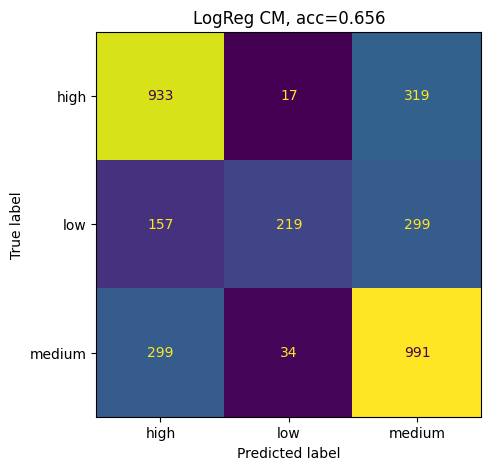

In [12]:
def plot_cm(y_true, y_pred, title):
    labels = sorted(np.unique(y_true))
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    fig, ax = plt.subplots(figsize=(5,5))
    disp.plot(ax=ax, values_format='d', colorbar=False)
    plt.title(title)
    plt.tight_layout()
    plt.show()

acc_nb = accuracy_score(y_test, y_pred_nb)
acc_lr = accuracy_score(y_test, y_pred_lr)
if acc_lr >= acc_nb:
    plot_cm(y_test, y_pred_lr, f"LogReg CM, acc={acc_lr:.3f}")
else:
    plot_cm(y_test, y_pred_nb, f"Naive Bayes CM, acc={acc_nb:.3f}")


In [14]:
param_grid = {
    'C': [0.1, 0.5, 1.0, 2.0],
    'solver': ['lbfgs'],
}
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

grid_lr = GridSearchCV(
    LogisticRegression(max_iter=1000, n_jobs=-1),
    param_grid=param_grid,
    scoring='f1_macro',
    cv=cv,
    n_jobs=-1,
    verbose=1
)

grid_lr.fit(X_train_vec, y_train)
print("Best params:", grid_lr.best_params_)
print("Best CV f1_macro:", round(grid_lr.best_score_, 4))

best_lr = grid_lr.best_estimator_
y_pred_best_lr = best_lr.predict(X_test_vec)

print("Tuned LogReg accuracy:", round(accuracy_score(y_test, y_pred_best_lr), 4))
print(classification_report(y_test, y_pred_best_lr))


Fitting 3 folds for each of 4 candidates, totalling 12 fits
Best params: {'C': 2.0, 'solver': 'lbfgs'}
Best CV f1_macro: 0.6167
Tuned LogReg accuracy: 0.6821
              precision    recall  f1-score   support

        high       0.69      0.75      0.72      1269
         low       0.77      0.43      0.55       675
      medium       0.65      0.75      0.70      1324

    accuracy                           0.68      3268
   macro avg       0.70      0.64      0.66      3268
weighted avg       0.69      0.68      0.68      3268



In [15]:
param_grid_nb = {'alpha': [0.1, 0.5, 1.0, 2.0]}
grid_nb = GridSearchCV(
    MultinomialNB(),
    param_grid=param_grid_nb,
    scoring='f1_macro',
    cv=cv,
    n_jobs=-1,
    verbose=1
)

grid_nb.fit(X_train_vec, y_train)
print("Best NB params:", grid_nb.best_params_)
print("Best NB CV f1_macro:", round(grid_nb.best_score_, 4))

best_nb = grid_nb.best_estimator_
y_pred_best_nb = best_nb.predict(X_test_vec)

print("Tuned NB accuracy:", round(accuracy_score(y_test, y_pred_best_nb), 4))
print(classification_report(y_test, y_pred_best_nb))


Fitting 3 folds for each of 4 candidates, totalling 12 fits
Best NB params: {'alpha': 0.1}
Best NB CV f1_macro: 0.6427
Tuned NB accuracy: 0.6851
              precision    recall  f1-score   support

        high       0.68      0.76      0.72      1269
         low       0.81      0.45      0.58       675
      medium       0.66      0.73      0.69      1324

    accuracy                           0.69      3268
   macro avg       0.72      0.65      0.66      3268
weighted avg       0.70      0.69      0.68      3268



In [16]:
lr_bal = LogisticRegression(
    max_iter=1000,
    n_jobs=-1,
    class_weight='balanced',
    solver='lbfgs'
)
lr_bal.fit(X_train_vec, y_train)
y_pred_lr_bal = lr_bal.predict(X_test_vec)

print("LogReg balanced accuracy:", round(accuracy_score(y_test, y_pred_lr_bal), 4))
print(classification_report(y_test, y_pred_lr_bal))


LogReg balanced accuracy: 0.6518
              precision    recall  f1-score   support

        high       0.69      0.70      0.69      1269
         low       0.55      0.60      0.58       675
      medium       0.67      0.63      0.65      1324

    accuracy                           0.65      3268
   macro avg       0.64      0.64      0.64      3268
weighted avg       0.65      0.65      0.65      3268



In [18]:
def top_terms_per_class(model, vectorizer, k=15):
    classes = model.classes_
    feature_names = np.array(vectorizer.get_feature_names_out())
    coefs = model.coef_
    for idx, c in enumerate(classes):
        topk = np.argsort(coefs[idx])[::-1][:k]
        print(f"\nTop terms for class '{c}':")
        print(", ".join(feature_names[topk]))

top_terms_per_class(best_lr if 'best_lr' in globals() else lr, vectorizer, k=15)



Top terms for class 'high':
critical, leading, crashes, failure, severe, outages, substantial, security systems, downtime, urgently, technical, outage, updates causing, compromised, significant

Top terms for class 'low':
impacting digital, sporadic, engagement digital, intermittent, outdated, likely, audience, access problems, crash investment, requesting update, saas, intermittently, feature, configuration errors, data using

Top terms for class 'medium':
sporadic, credentials, optimization tools, improvements, settings issue, various software, information integrating, systems checking, achieve, request information, platform encountered, demonstrate, details, related digital, plan
